In [31]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
# sns.set_style('whitegrid')
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('text', usetex=True)


In [32]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results")

In [33]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    
    
    y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model == "rf":
            eta= eta[:, 1]

    if return_sizes:
        return metric, data["encode_time"], data["train_time"], data["test_time"], eta, data["train_size"], data["test_size"]
    else:
        return metric, data["encode_time"], data["train_time"], data["test_time"], eta

# DUD-E results

In [34]:
def aggregate_dude_results(dataset, split):
    

    f, ax = plt.subplots(1,3, figsize=(20,6), sharex=True)
    ax = ax.flatten()

    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green"), ("rf", "pink")]:
#     for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:

        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"{dataset}*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []
        
        
        for path in data_path_list:
            
            target = path.stem.split("_")[1]
            split = path.stem.split(".")[0].split("_")[-1]
            split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
            split_df = pd.read_csv(split_file)
            
            train_size = split_df[split_df["subset"] == "train"].shape[0] 
            test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            m, encode_time, train_time, test_time, eta = load_pkl(path, model=model, return_sizes=False)
                
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            

        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], color=color, label=model)
    #     print(encode_time_list)

        sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)

#     ax[0].axhline(y=0.5, color='k', linestyle='--', zorder=0)
    ax[0].set_ylabel("roc-auc-score")
    ax[0].set_xlabel("train set size")

#     ax[1].set_ylabel("encode-time (s)")
#     ax[1].set_yscale("log")
#     ax[1].set_xlabel("train set size")

#     ax[2].set_ylabel("train-time-per-epoch (s)")
#     ax[2].set_xlabel("train set size")

#     ax[3].set_ylabel("test-time (s)")
#     ax[3].set_xlabel("train set size")

    plt.legend()
    return f, ax




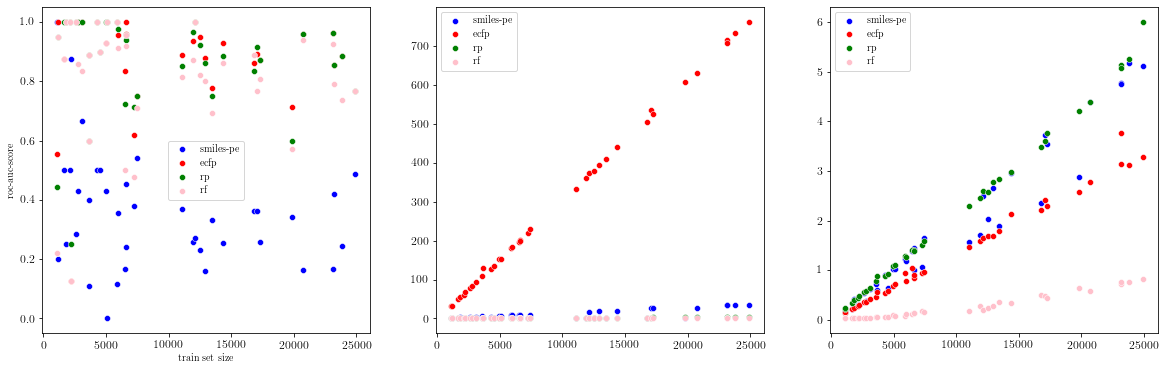

In [35]:
dude_f, dude_ax = aggregate_dude_results(dataset="dude", split="random")
# plt.savefig('dude-results-all.png', dpi=600)

# DUDE- HD-CUDA

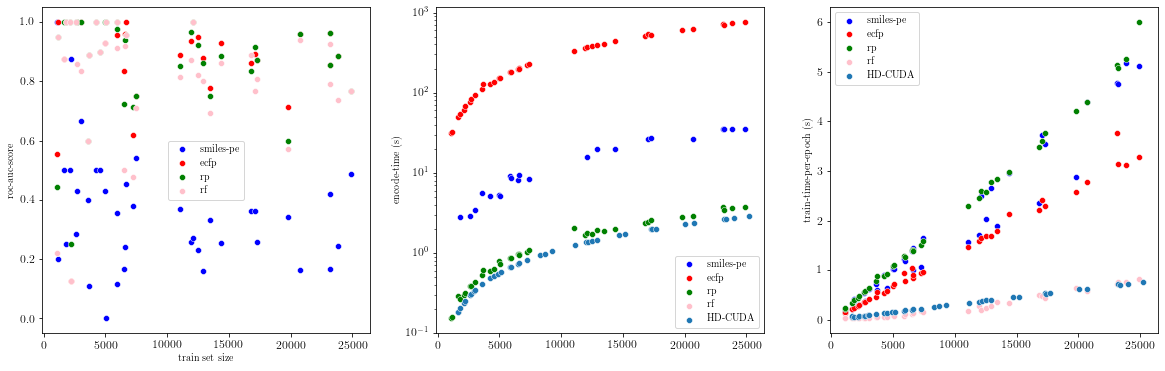

In [36]:
def hd_cuda_main(f, ax):
    root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/deepchem_feats")
    
    train_size_list = []
    encode_time_list = []
    train_time_list = []
    test_time_list = []

#     import pdb
#     pdb.set_trace()
    for path in root_dir.glob("*/ecfp/run.out"):
#         print(path)
#         '''
        df = pd.read_csv(path, header=None)
#         print(df.head(df.shape[0]))
#         '''
        num_train_epochs = int(df.loc[4][0])
        
        encode_time = float(df.loc[21][0].split(' ')[-1]) /1000
        train_time = float(df.loc[22][0].split(' ')[-1]) / 1000 / num_train_epochs
        test_time = float(df.loc[23][0].split(' ')[-1]) /1000
        train_size = int(df.loc[13][0])
        
        encode_time_list.append(encode_time)
        train_time_list.append(train_time)
        test_time_list.append(test_time)
        train_size_list.append(train_size)
    
    sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
    sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
    sorted_test_time_list = [x for _, x in sorted(zip(train_size_list, test_time_list), key=lambda pair: pair[0])]
    sorted_train_size_list = sorted(train_size_list)
#         '''
        
    sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], label="HD-CUDA")
    ax[1].set_ylabel("encode-time (s)")
    sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], label="HD-CUDA")
    ax[2].set_ylabel("train-time-per-epoch (s)")
#     sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[2], label="HD-CUDA")
#     ax[2].set_ylabel("test-time (s)")
    return f, ax

        
hd_cuda_main(f=dude_f, ax=dude_ax)
dude_ax[1].set_yscale("log")
dude_f

# OpenHD 

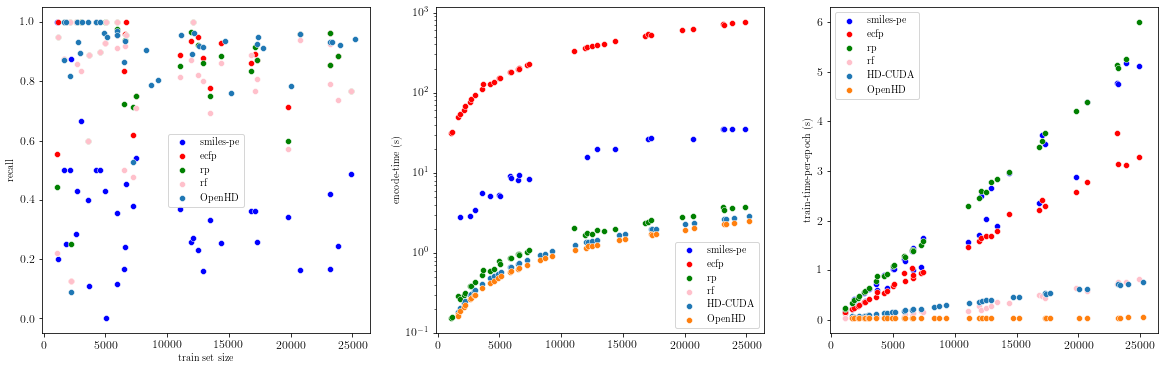

In [37]:
def open_hd_main(f, ax):
    root_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/deepchem_feats")
    
    metric_list = []
    train_size_list = []
    encode_time_list = []
    train_time_list = []
    test_time_list = []

#     import pdb
#     pdb.set_trace()
    for path in root_dir.glob("*/ecfp/open_hd_run.out"):
#         print(path)
#         '''
        df = pd.read_csv(path, header=None,  delim_whitespace=True)
#         print(df.head(df.shape[0]))
#         '''
#         num_train_epochs = int(df.loc[4][0])
        
#         encode_time = float(df.loc[21][0].split(' ')[-1]) /1000
#         train_time = float(df.loc[22][0].split(' ')[-1]) / 1000 / num_train_epochs
#         test_time = float(df.loc[23][0].split(' ')[-1]) /1000
#         train_size = int(df.loc[13][0])

            # adding the sum of the encode times for train and test
        encode_time = float(df.iloc[2][2]) + float(df.iloc[3][2])
        
            # sum of single pass and retrain
#         train_time = float(df.iloc[4][2]) + sum([float(df.iloc[x][3]) for x in range(5, 15)])
        train_time = sum([float(df.iloc[x][3]) for x in range(5, 15)])

        train_time = train_time / 11 # normalize for num epochs
        test_time = float(df.iloc[15][4])
        train_size = int(df.iloc[0][1][:-1])
        metric = float(df.iloc[17][1])
        
        
        encode_time_list.append(encode_time)
        train_time_list.append(train_time)
        test_time_list.append(test_time)
        train_size_list.append(train_size)
        metric_list.append(metric)
    
    sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
    sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
    sorted_test_time_list = [x for _, x in sorted(zip(train_size_list, test_time_list), key=lambda pair: pair[0])]
    sorted_train_size_list = sorted(train_size_list)
    sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
    
    sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], label="OpenHD")
    ax[0].set_ylabel("recall")
    sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], label="OpenHD")
    ax[1].set_ylabel("encode-time (s)")
    sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], label="OpenHD")
    ax[2].set_ylabel("train-time-per-epoch (s)")
#     sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[2], label="HD-CUDA")
#     ax[2].set_ylabel("test-time (s)")
    return f, ax

        
open_hd_main(f=dude_f, ax=dude_ax)
# dude_ax[1].set_yscale("log")
dude_f

# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [30]:
def plot_lit_pcba_results(split):
    
#     f, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
    f, ax = plt.subplots(1,1, figsize=(9,6), sharex=True)

#     ax = ax.flatten()
#     for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green"), ("rf", "pink")]:
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:

#     for model, color in [("ecfp", "blue")]:

        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"lit_pcba_*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []


        for path in data_path_list:
            
            target = path.stem.split("_")[2]
#             split = path.stem.split(".")[0].split("_")[-1]
#             split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
#             split_df = pd.read_csv(split_file)
            
#             train_size = split_df[split_df["subset"] == "train"].shape[0]
            
#             test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            
            m, encode_time, train_time, test_time, eta, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
#             print(path, train_size)

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            

        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax, color=color, label=model)
#         sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
#         sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)


#         sns.scatterplot(x=list(range(len(metric_list))), y=metric_list, ax=ax[0], color=color, label=model)
#         sns.scatterplot(x=list(range(len(encode_time_list))), y=encode_time_list, ax=ax[1], color=color, label=model)
#         sns.scatterplot(x=list(range(len(train_time_list))), y=train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=list(range(len(test_time_list))), y=test_time_list, ax=ax[3], color=color, label=model)


    ax.axhline(y=0.5, color='k', linestyle='--', zorder=0)
    ax.set_ylabel("roc-auc-score")
    ax.set_xlabel("train set size")
#     ax[0].set_xscale("log")

#     ax[1].set_ylabel("encode-time (s)")
#     ax[1].set_yscale("log")
#     ax[1].set_xlabel("train set size")

#     ax[2].set_ylabel("train-time-per-epoch (s)")
#     ax[2].set_xlabel("train set size")

#     ax[3].set_ylabel("test-time (s)")
#     ax[3].set_xlabel("train set size")

    plt.legend()
    return f, ax

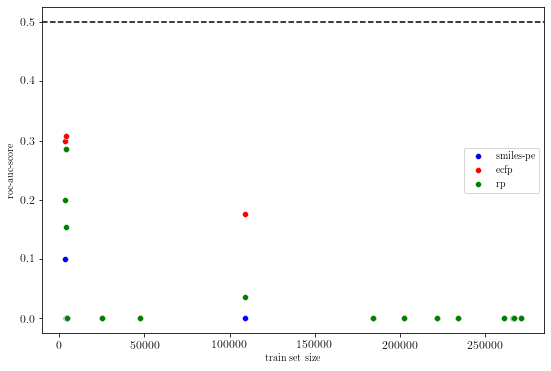

In [25]:
plot_lit_pcba_results(split="random_strat_split")
plt.savefig('lit-pcba-results-all.png', dpi=600)

# BBBP Benchmark

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(y_pred, y_true, ax):
#     f, ax = plt.subplots(1,1, figsize=(10,6))

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0,1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
    disp.plot(cmap="Purples", ax=ax)

In [11]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

def plot_roc_curve(y_score, y_true, ax, name):
    
    fpr, tpr, thresholds = roc_curve(y_score=y_score, y_true=y_true)
    roc_auc = auc(fpr, tpr)


    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    disp.plot(ax=ax, name=name)

In [12]:
def plot_dist_plot(y_score, y_true, ax):
    
    neg_dist = y_score[y_true == 0]
    pos_dist = y_score[y_true == 1]
    
    
    sns.distplot(neg_dist, color="blue", ax=ax)
    sns.distplot(pos_dist, color="red", ax=ax)
    

In [13]:
def bbbp_main():
    
    
    path_list = ["/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.smiles-pe.pkl",
                "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.ecfp.pkl",
                "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.rp.pkl",
                "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/bbbp_result.rf.pkl"]
    
    
    roc_f, roc_ax = plt.subplots(1,1, figsize=(10,6))

    
    for path in path_list:
        
        model = path.split(".")[-2]
        with open(path, "rb") as handle:
            data = pickle.load(handle)

            name = path.split('.')[-2]
            
            
            y_pred = data[0]['y_pred']
            y_true = data[0]['y_true']
            y_score = data[0]['eta']
            
            if model == "rf":
                y_score = y_score[:, 1]
            
            
            
            
            
#             confus_f, confus_ax = plt.subplots(1,1, figsize=(10,6))
#             plot_confusion_matrix(y_pred=y_pred, y_true=y_true, ax=confus_ax)
#             confus_f.suptitle(name)
            
            plot_roc_curve(y_score=y_score, y_true=y_true, ax=roc_ax, name=name)
            
#             dist_f, dist_ax = plt.subplots(1,1, figsize=(10,6))
#             plot_dist_plot(y_score=y_score, y_true=y_true, ax=dist_ax)
#             dist_f.suptitle(name)
            
            
    roc_ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    
    roc_f.suptitle("Blood-Brain-Barrier Permeability Reciever Operating Curve")
    plt.savefig("bbbp_result_roc.png", dpi=600, bbox_inches="tight")


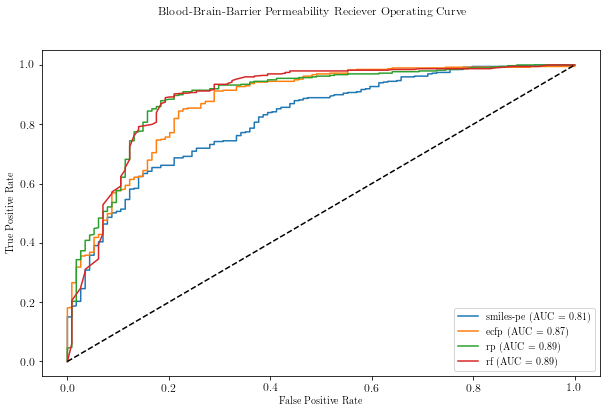

In [14]:
bbbp_main()

In [15]:
def plot_lit_pcba_results(split):
    
    f, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
    ax = ax.flatten()
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:
#     for model, color in [("ecfp", "blue")]:

        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        data_path_list = list(data_p.glob(f"lit_pcba_*_{split}.{model}.pkl"))
        
        train_size_list = []
        test_size_list = []

        
        
        for path in data_path_list:
            
            target = path.stem.split("_")[2]
#             split = path.stem.split(".")[0].split("_")[-1]
#             split_file = f"/usr/WS2/atom/gbsa_modeling/dude_smiles/{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_{split}_{split}.csv"
#             split_df = pd.read_csv(split_file)
            
#             train_size = split_df[split_df["subset"] == "train"].shape[0]
            
#             test_size = split_df[split_df["subset"] == "test"].shape[0]
            
            
            m, encode_time, train_time, test_time, eta, train_size, test_size = load_pkl(path, return_sizes=True)
            print(path, train_size)

            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
            

        sorted_metric_list = [x for _, x in sorted(zip(train_size_list, metric_list), key=lambda pair: pair[0])]
        sorted_encode_time_list = [x for _, x in sorted(zip(train_size_list, encode_time_list), key=lambda pair: pair[0])]
        sorted_train_time_list = [x for _, x in sorted(zip(train_size_list, train_time_list), key=lambda pair: pair[0])]
        sorted_test_time_list = [x for _, x in sorted(zip(test_size_list, test_time_list), key=lambda pair: pair[0])]
        sorted_train_size_list = sorted(train_size_list)
        
        
        sns.scatterplot(x=sorted_train_size_list, y=sorted_metric_list, ax=ax[0], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_encode_time_list, ax=ax[1], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_train_time_list, ax=ax[2], color=color, label=model)
        sns.scatterplot(x=sorted_train_size_list, y=sorted_test_time_list, ax=ax[3], color=color, label=model)


#         sns.scatterplot(x=list(range(len(metric_list))), y=metric_list, ax=ax[0], color=color, label=model)
#         sns.scatterplot(x=list(range(len(encode_time_list))), y=encode_time_list, ax=ax[1], color=color, label=model)
#         sns.scatterplot(x=list(range(len(train_time_list))), y=train_time_list, ax=ax[2], color=color, label=model)
#         sns.scatterplot(x=list(range(len(test_time_list))), y=test_time_list, ax=ax[3], color=color, label=model)


#     ax[0].axhline(y=0.5, color='k', linestyle='--')
#     ax[0].set_ylabel("roc-auc-score")
#     ax[0].set_xlabel("train set size")
# #     ax[0].set_xscale("log")

#     ax[1].set_ylabel("encode-time (s)")
#     ax[1].set_yscale("log")
#     ax[1].set_xlabel("train set size")

#     ax[2].set_ylabel("train-time-per-epoch (s)")
#     ax[2].set_xlabel("train set size")

#     ax[3].set_ylabel("test-time (s)")
#     ax[3].set_xlabel("train set size")

#     plt.legend()
#     return f, ax




def sider_main():
    
    
    model_dict = {"model": [], "task": [], "roc-auc": []}
    for model, color in [("smiles-pe", "blue"), ("ecfp", "red"), ("rp", "green")]:

        data_path_list = list(data_p.glob(f"sider_*.{model}.pkl"))
        
        
#         print(data_path_list)
        
        

        for path in data_path_list:
            with open(path, "rb") as handle:
                
                
                data = pickle.load(handle)

                name = str(path).split('.')[-2]
                task = int(str(path).split('.')[0][-1])
            
                y_pred = data[0]['y_pred']
                y_true = data[0]['y_true']
                y_score = data[0]['eta']
        
                fpr, tpr, thresholds = roc_curve(y_score=y_score, y_true=y_true)
                roc_auc = auc(fpr, tpr)
                
                model_dict["model"].append(model)
                model_dict["task"].append(task)
                model_dict["roc-auc"].append(roc_auc)

    
    df = pd.DataFrame(model_dict)
    g = sns.catplot(data=df, x="model", y="roc-auc", kind="box", palette="deep", height=6, aspect=1.25)

    
    g.fig.suptitle("SIDER ROC-AUC Distribution Over Tasks")
    plt.savefig("sider_result_roc.png", dpi=600, bbox_inches="tight")


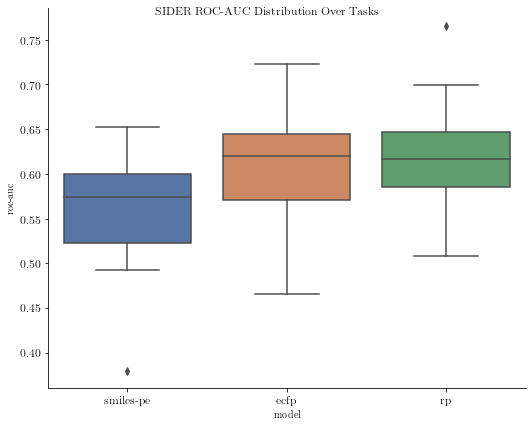

In [16]:
sider_main()